## Setup

The first step is to make sure the `ART` library is available in your kernel.

Clone the corresponding git repository:


`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.



We can then add library to the path and do the necessary import:


In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
    
from art.core import *                                  


## User parameters

In [2]:
user_params = {
    'n_instances': 100
}

Define true response function:

In [ ]:
def true_function(x, dimension):

    f = 0.
    for i in range(dimension):
        f += x[i] ** 4 - 16 * x[i] ** 2 + 5 * x[i]

    f *= 1 / dimension
    return -1.*f

In [3]:
def f1(x, dimension):

    term1 = 0.
    term2 = 0.
    for i in range(dimension):
        term1 += (x[i] - 5)**2
        term2 += x[i]**2

    return -1*(1/dimension * term1 + np.exp(-term2)) + 25

In [4]:
dim = 10


In [5]:
global_optimum_value = {1: 25.,
                        2: 78.332}
global_optimum = {1: 5.*np.ones(dim),
                  2: -2.903534*np.ones(dim)}

lb = {1: -5, 2: -5}
ub = {1: 10, 2: 5}

## Assign input parameters

In [6]:
func_number = 1
n_cycles = 2
alphas = [None, 1.]
        
global_optimum_value = global_optimum_value[func_number]
global_optimum = global_optimum[func_number]
lb = lb[func_number]
ub = ub[func_number]

In [12]:
# Additional variables for plotting models
n_points = 50
x1 = np.linspace(lb,ub,n_points)
x2 = np.linspace(lb,ub,n_points)
X1, Y1 = np.meshgrid(x1, x2)

# pred_mean = np.zeros((n_points,n_points))
# pred_std = np.zeros((n_points,n_points))
# n_draws = 5000 # for sampling posterior samples

In [8]:
# Create file with bounds
bounds_file = '../data/sim_data_bounds.csv'
# df = pd.DataFrame(columns=['Variable', 'Min', 'Max', 'Scaling'])
# df['Variable'] = ['x_' + str(i) for i in range(1, dim + 1)]
# df['Min'] = lb*np.ones(dim)
# df['Max'] = ub*np.ones(dim)
# df['Scaling'] = np.ones(dim)
# df = df.set_index('Variable')
# df.to_csv(path_or_buf=bounds_file)


Plot functions for D=2

In [ ]:
dim = 2
# 1
Z1 = f1(np.array([X1, Y1]),dim)
f_max1 = f1([5,5],dim)
min_z1 = -100

fig = plt.figure(figsize=(4, 4.5), dpi=300)

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X1, Y1, Z1, rstride=10, cstride=1, cmap=cmap, alpha=0.5,edgecolor='None')
ax.scatter(5, 5, min_z1, s=50, c='r',edgecolor='r')
ax.set_zlim3d(min_z1, f_max1)
cset = ax.contour(X1, Y1, Z1, zdir='z', offset=min_z1, cmap=cmap)
cset = ax.contour(X1, Y1, Z1, zdir='x', offset=-5, cmap=cmap)
cset = ax.contour(X1, Y1, Z1, zdir='y', offset=10, cmap=cmap)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$F_E(x)$')
plt.tight_layout()
fig.savefig(f'F_1.png')

# 2
fig = plt.figure(figsize=(4, 4.5), dpi=300)
x1 = np.linspace(-5,5,50)
x2 = np.linspace(-5,5,50)
X2, Y2 = np.meshgrid(x1, x2)
Z2 = f2(np.array([X2, Y2]),dim)
f_max2 = f2([-2.903534, -2.903534],dim)
min_z2 = -250
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X2, Y2, Z2, rstride=10, cstride=1, cmap=cmap, alpha=0.5,edgecolor='None')
ax.set_zlim3d(min_z2, f_max2)
ax.scatter(-2.903534, -2.903534, min_z2, s=50, c='r',edgecolor='r')
cset = ax.contour(X2, Y2, Z2, zdir='z', offset=min_z2, cmap=cmap)
cset = ax.contour(X2, Y2, Z2, zdir='x', offset=-5, cmap=cmap)
cset = ax.contour(X2, Y2, Z2, zdir='y', offset=5, cmap=cmap)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$F_M(x)$')
plt.tight_layout()
fig.savefig(f'F_2.png')


## Cycle 1

In [ ]:
cycle = 1

In [9]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': ['x_' + str(i) for i in range(1, dim + 1)],                    # input variables, i.e. features
    'num_recommendations': user_params['n_instances'],    # one of them will be wild type
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 1420,                                               # seed for number random generator
    'output_directory': '../results/'  # directory to store this output
}


Generate training data set using ART, LHS

In [10]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
95,9.528479,9.954947,-3.629019,5.815086,5.540921,4.298939,3.413892,7.971507,5.732656,-0.076867
96,-2.641253,-2.616314,-3.782925,-2.737033,1.292883,6.744400,0.624413,0.180037,1.150399,1.802856
97,7.242011,5.247596,6.986206,-4.370694,-2.695209,3.189057,6.168330,5.292103,3.881761,4.784728
98,-4.797648,2.268627,3.270088,1.151544,-0.713763,3.706340,3.182821,9.509232,5.342007,4.369222
99,1.358523,-2.274011,-4.066570,7.429488,-4.665049,-4.338988,0.977391,-2.984230,-3.525951,7.600196


Save simulated cycle 1 data into EDD-style files

In [12]:
X = art.recommendations.values
y = f1(X.T, dim).reshape(-1, 1)
training_data_file = f'../data/sim_data_training.csv'
utils.save_edd_csv(X, y, art.input_var, training_data_file)


## Cycle 2

In [15]:
cycle += 1

In [13]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': ['x_' + str(i) for i in range(1, dim + 1)],                    # input variables, i.e. features
    'response_var': ['y'],
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': None,
    'num_recommendations': 16,  
    'verbose': 0,
    'seed': 42,                                               # seed for number random generator
    'output_directory': '../results/'  # directory to store this output
}


Best pipeline: GradientBoostingRegressor(ElasticNetCV(Normalizer(input_matrix, Normalizer__norm=l2), ElasticNetCV__l1_ratio=1.0, ElasticNetCV__tol=0.01), GradientBoostingRegressor__alpha=0.9, GradientBoostingRegressor__learning_rate=DEFAULT, GradientBoostingRegressor__loss=DEFAULT, GradientBoostingRegressor__max_depth=DEFAULT, GradientBoostingRegressor__max_features=0.2, GradientBoostingRegressor__min_samples_leaf=13, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9000000000000001)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 788.77draws/s]
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.179889,5.561633,0.190668,6.871420e-02,0.999196
Random Forest Regressor,2.031005,47.844422,1.833461,7.486561e+00,0.912367
TPOT Regressor,1.032095,33.225211,1.142048,2.369493e+00,0.972264
Support Vector Regressor,5.142429,62.680914,4.504737,4.673723e+01,0.452922
Kernel Ridge Regressor,1.923849,47.302945,1.636990,6.380932e+00,0.925309
K-NN Regressor,4.496115,137.718103,3.772206,3.444459e+01,0.596812
Gaussian Process Regressor,0.000003,0.000074,0.000004,2.542142e-11,1.000000
Gradient Boosting Regressor,0.224413,7.142154,0.209038,9.405821e-02,0.998899
Ensemble Model,0.004960,0.107828,0.004375,4.374047e-05,0.999999


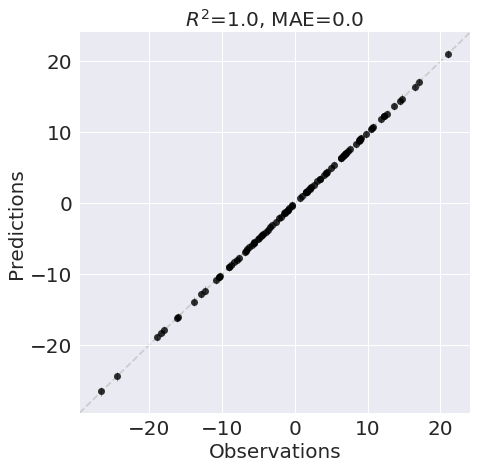

Finished 2.00 percent in 4.202321 s Acceptance rate = 0.7865Adding DE jump with weight 20
Finished 99.00 percent in 179.826767 s Acceptance rate = 0.448293
Run Complete


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,5.242814,4.708435,5.419187,4.885291,3.760537,5.123070,4.548707,5.403047,5.743124,4.935651,24.646050
1,4.739868,4.597311,5.825493,4.629076,5.811119,3.822217,4.964807,5.659868,4.600965,5.561504,24.517306
2,5.667973,5.206287,5.247146,4.082644,4.948181,5.148449,5.890127,6.271013,5.554818,5.346214,24.485581
3,5.014436,4.913761,5.487262,6.092514,6.420485,4.712326,4.258820,4.584529,4.311284,5.143213,24.476371
4,4.303273,4.476750,5.061011,4.534674,5.751372,5.106332,4.902643,4.732441,5.628924,6.572946,24.471578
5,5.981369,5.146391,3.979415,4.053532,4.542317,4.156665,5.119402,4.132194,4.183406,5.363055,24.431280
6,4.923553,5.365302,6.399724,5.883000,5.304723,5.282157,5.837361,4.092775,5.087804,5.774294,24.409138
7,4.997508,3.686236,5.803596,4.813877,4.277179,4.483708,5.926332,5.955806,4.785289,4.436606,24.402015
8,4.722174,4.245861,4.286643,4.345317,6.244807,4.983840,5.010931,3.979099,4.502042,6.138471,24.388871
9,4.752739,4.310847,5.054370,4.049122,3.710961,6.261578,4.496185,5.409283,5.617785,4.532793,24.366217


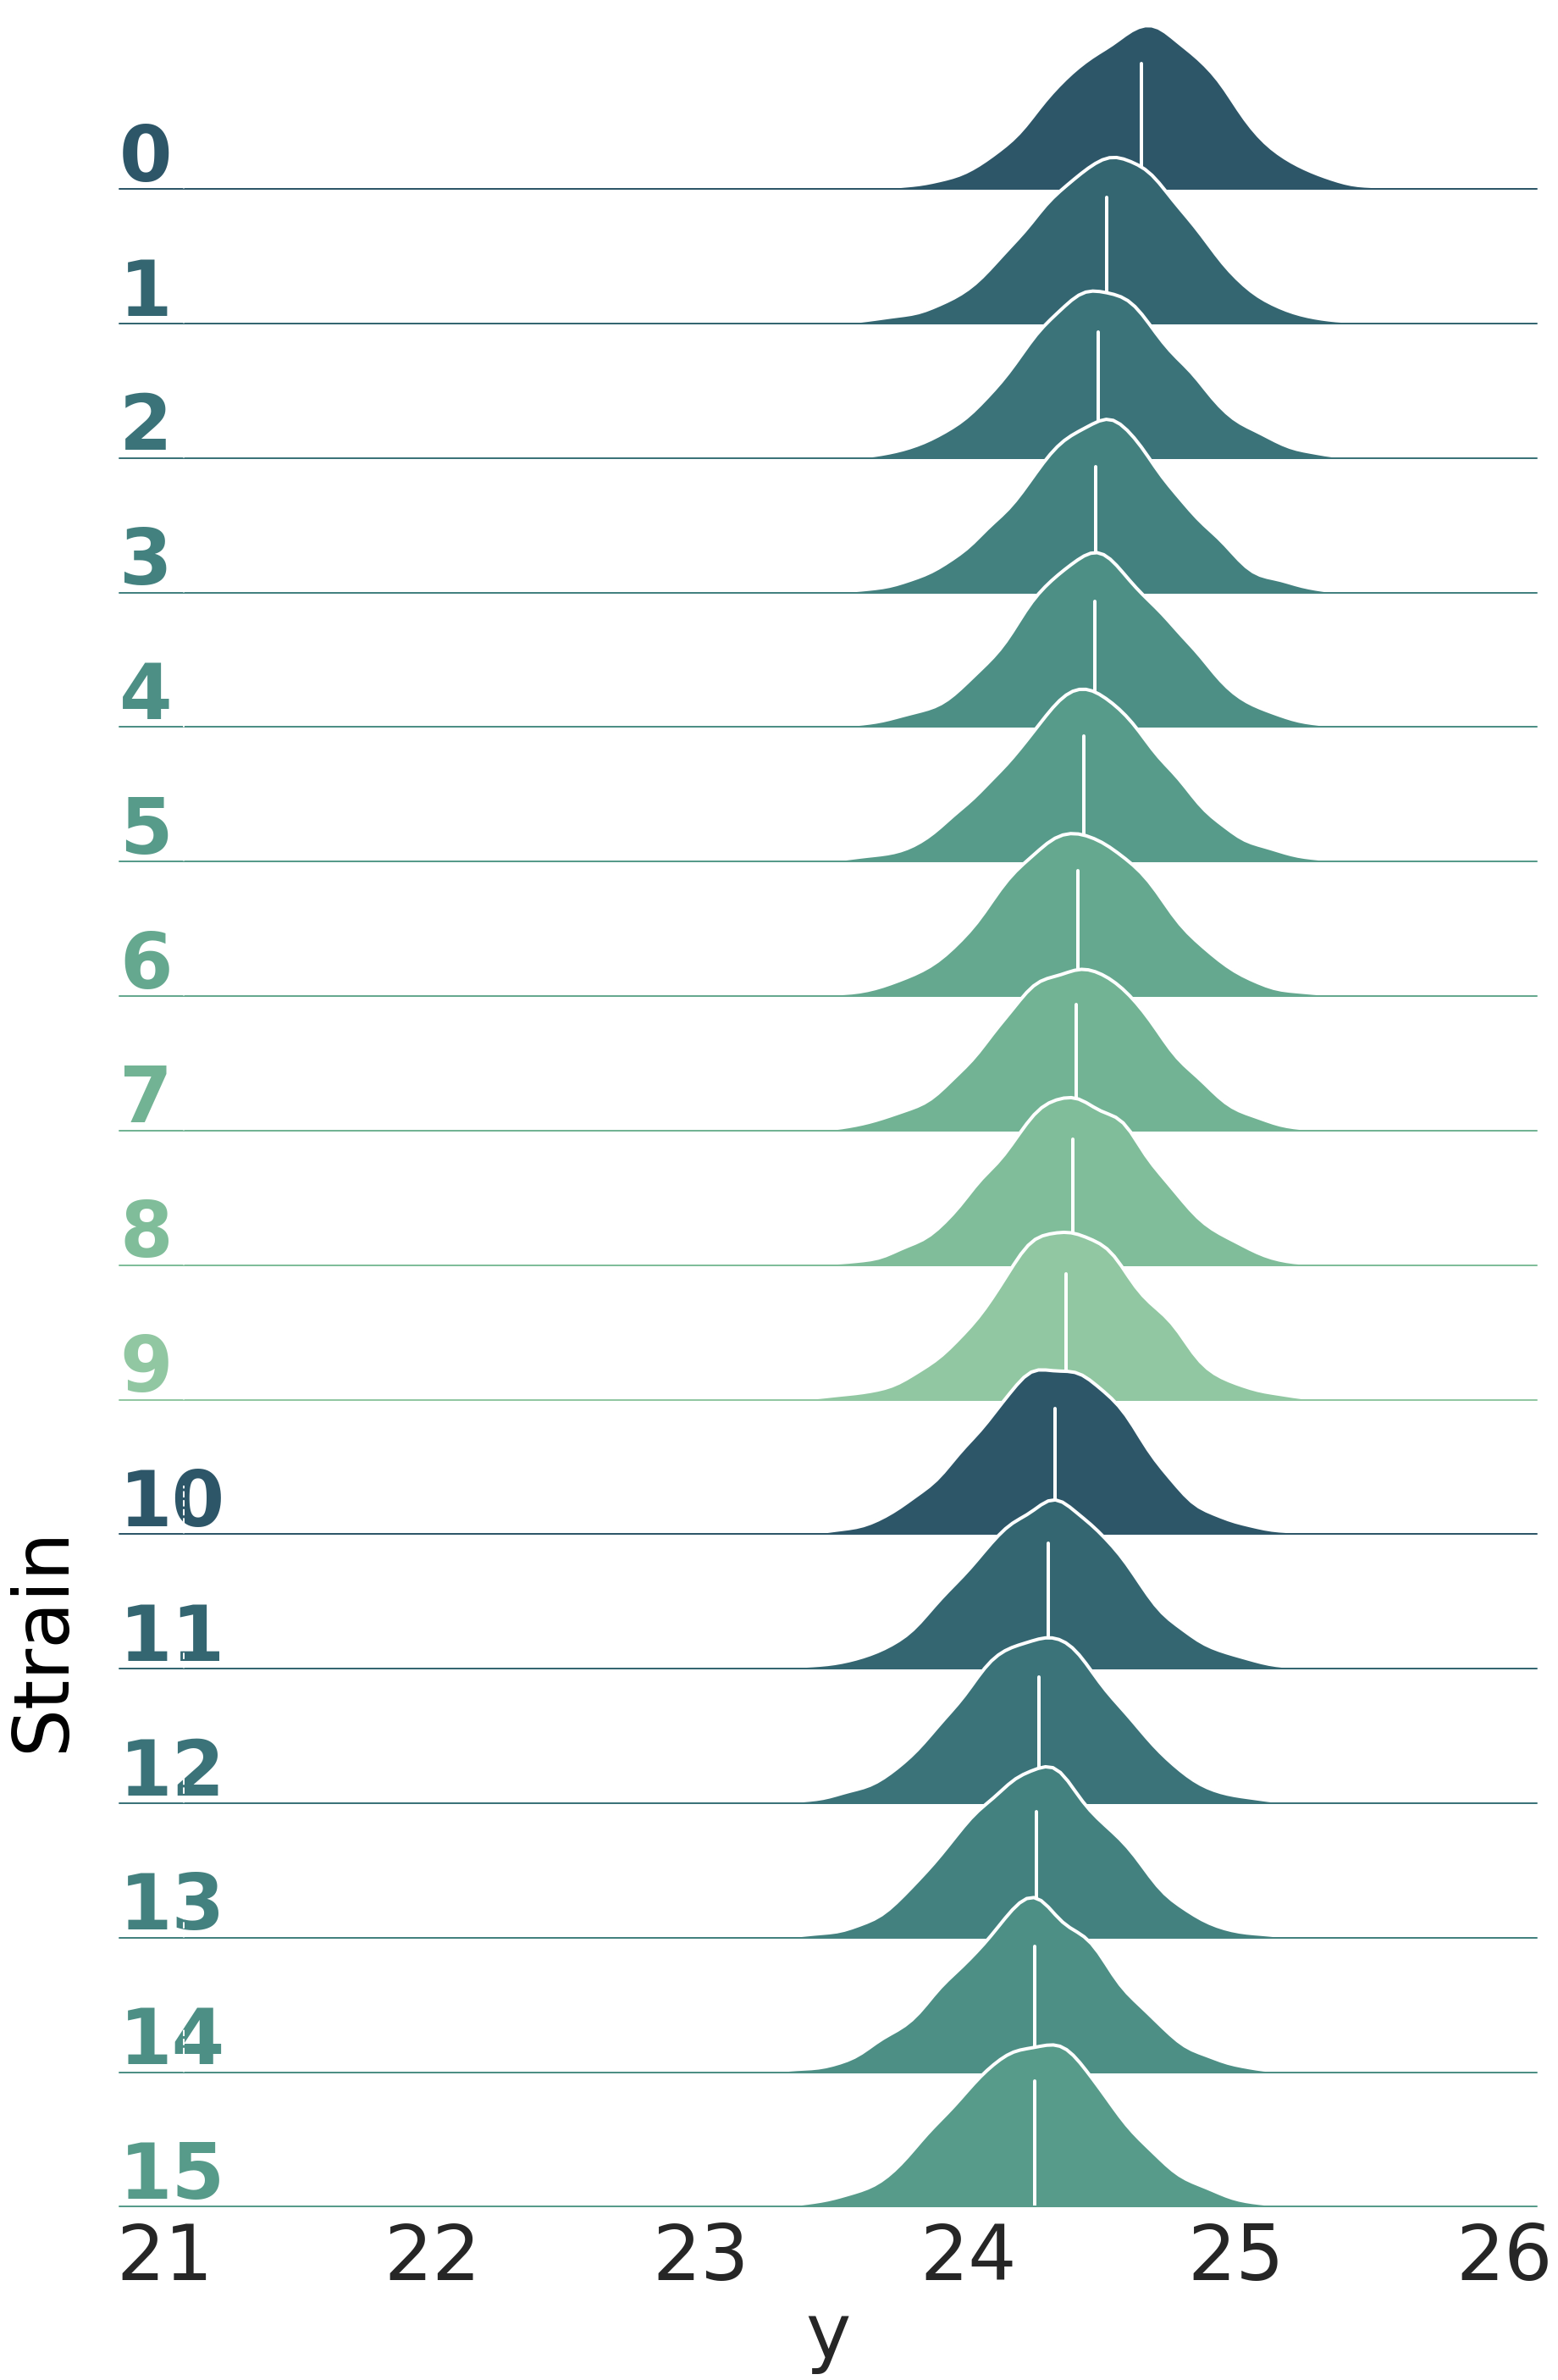

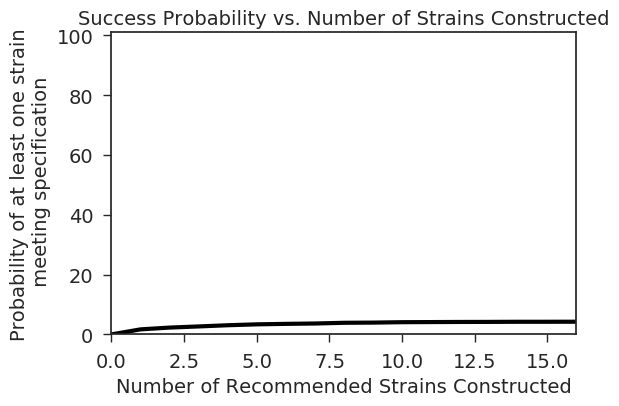

CPU times: user 6min 21s, sys: 1min 4s, total: 7min 25s
Wall time: 6min 13s


In [14]:
%%time
df = utils.load_study(data_file=training_data_file)
art = RecommendationEngine(df, **art_params)

In [16]:
# Save recommendations for the next cycle
file_path = f'{art.outDir}/recommendations_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

In [17]:
# Save data for the next cycle
X_new = art.recommendations.values[:, :-1]
y_new = f1(X_new.T, dim).reshape(-1, 1)
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, file_name)


## Cycle 3

In [15]:
cycle += 1

In [13]:
art_params['alpha'] = 0.5


Best pipeline: GradientBoostingRegressor(ElasticNetCV(Normalizer(input_matrix, Normalizer__norm=l2), ElasticNetCV__l1_ratio=1.0, ElasticNetCV__tol=0.01), GradientBoostingRegressor__alpha=0.9, GradientBoostingRegressor__learning_rate=DEFAULT, GradientBoostingRegressor__loss=DEFAULT, GradientBoostingRegressor__max_depth=DEFAULT, GradientBoostingRegressor__max_features=0.2, GradientBoostingRegressor__min_samples_leaf=13, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9000000000000001)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 788.77draws/s]
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.179889,5.561633,0.190668,6.871420e-02,0.999196
Random Forest Regressor,2.031005,47.844422,1.833461,7.486561e+00,0.912367
TPOT Regressor,1.032095,33.225211,1.142048,2.369493e+00,0.972264
Support Vector Regressor,5.142429,62.680914,4.504737,4.673723e+01,0.452922
Kernel Ridge Regressor,1.923849,47.302945,1.636990,6.380932e+00,0.925309
K-NN Regressor,4.496115,137.718103,3.772206,3.444459e+01,0.596812
Gaussian Process Regressor,0.000003,0.000074,0.000004,2.542142e-11,1.000000
Gradient Boosting Regressor,0.224413,7.142154,0.209038,9.405821e-02,0.998899
Ensemble Model,0.004960,0.107828,0.004375,4.374047e-05,0.999999


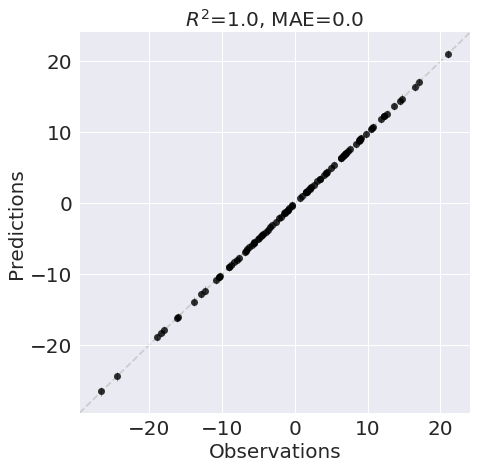

Finished 2.00 percent in 4.202321 s Acceptance rate = 0.7865Adding DE jump with weight 20
Finished 99.00 percent in 179.826767 s Acceptance rate = 0.448293
Run Complete


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,5.242814,4.708435,5.419187,4.885291,3.760537,5.123070,4.548707,5.403047,5.743124,4.935651,24.646050
1,4.739868,4.597311,5.825493,4.629076,5.811119,3.822217,4.964807,5.659868,4.600965,5.561504,24.517306
2,5.667973,5.206287,5.247146,4.082644,4.948181,5.148449,5.890127,6.271013,5.554818,5.346214,24.485581
3,5.014436,4.913761,5.487262,6.092514,6.420485,4.712326,4.258820,4.584529,4.311284,5.143213,24.476371
4,4.303273,4.476750,5.061011,4.534674,5.751372,5.106332,4.902643,4.732441,5.628924,6.572946,24.471578
5,5.981369,5.146391,3.979415,4.053532,4.542317,4.156665,5.119402,4.132194,4.183406,5.363055,24.431280
6,4.923553,5.365302,6.399724,5.883000,5.304723,5.282157,5.837361,4.092775,5.087804,5.774294,24.409138
7,4.997508,3.686236,5.803596,4.813877,4.277179,4.483708,5.926332,5.955806,4.785289,4.436606,24.402015
8,4.722174,4.245861,4.286643,4.345317,6.244807,4.983840,5.010931,3.979099,4.502042,6.138471,24.388871
9,4.752739,4.310847,5.054370,4.049122,3.710961,6.261578,4.496185,5.409283,5.617785,4.532793,24.366217


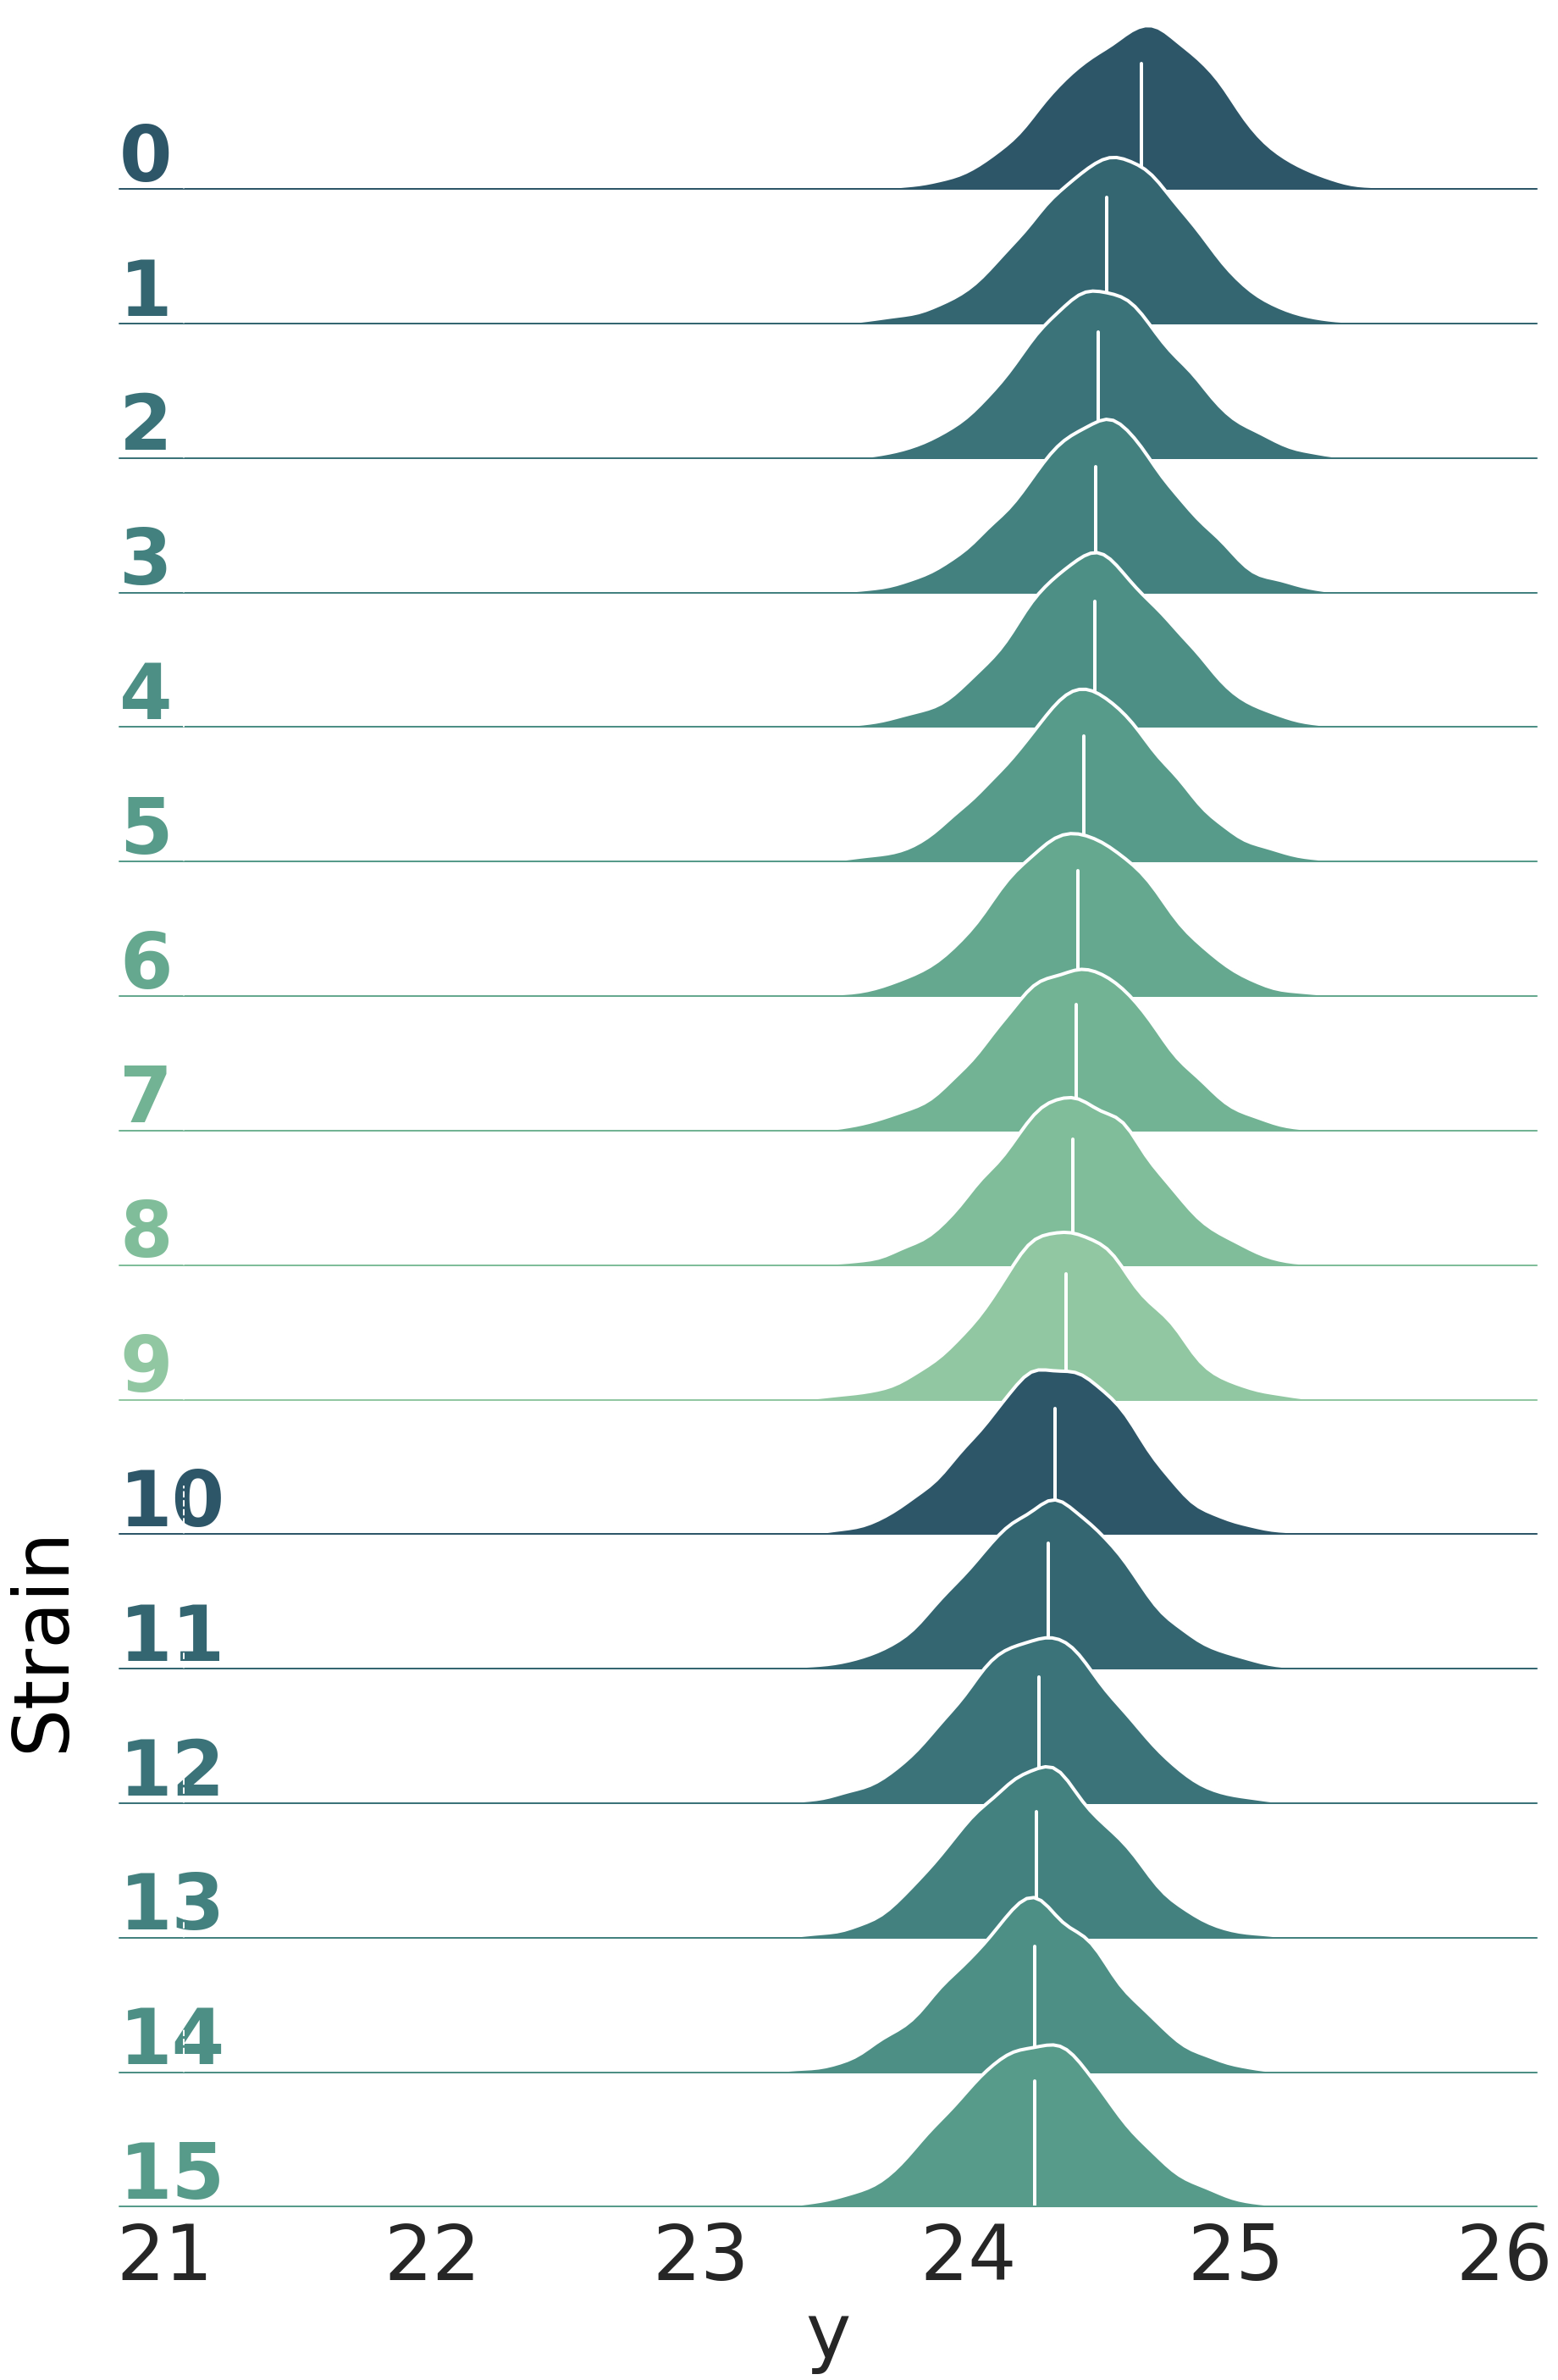

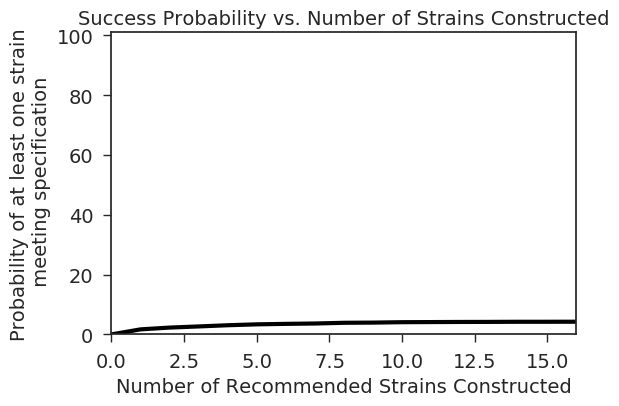

CPU times: user 6min 21s, sys: 1min 4s, total: 7min 25s
Wall time: 6min 13s


In [14]:
%%time
data_file = f'../data/sim_data_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)
art = RecommendationEngine(df, **art_params)

In [16]:
# Save recommendations for the next cycle
file_path = f'{art.outDir}/recommendations_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

In [17]:
# Save data for the next cycle
X_new = art.recommendations.values[:, :-1]
y_new = f1(X_new.T, dim).reshape(-1, 1)
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, file_name)


## Cycle 4

In [15]:
cycle += 1

In [13]:
art_params['alpha'] = 1.


Best pipeline: GradientBoostingRegressor(ElasticNetCV(Normalizer(input_matrix, Normalizer__norm=l2), ElasticNetCV__l1_ratio=1.0, ElasticNetCV__tol=0.01), GradientBoostingRegressor__alpha=0.9, GradientBoostingRegressor__learning_rate=DEFAULT, GradientBoostingRegressor__loss=DEFAULT, GradientBoostingRegressor__max_depth=DEFAULT, GradientBoostingRegressor__max_features=0.2, GradientBoostingRegressor__min_samples_leaf=13, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9000000000000001)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 788.77draws/s]
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.179889,5.561633,0.190668,6.871420e-02,0.999196
Random Forest Regressor,2.031005,47.844422,1.833461,7.486561e+00,0.912367
TPOT Regressor,1.032095,33.225211,1.142048,2.369493e+00,0.972264
Support Vector Regressor,5.142429,62.680914,4.504737,4.673723e+01,0.452922
Kernel Ridge Regressor,1.923849,47.302945,1.636990,6.380932e+00,0.925309
K-NN Regressor,4.496115,137.718103,3.772206,3.444459e+01,0.596812
Gaussian Process Regressor,0.000003,0.000074,0.000004,2.542142e-11,1.000000
Gradient Boosting Regressor,0.224413,7.142154,0.209038,9.405821e-02,0.998899
Ensemble Model,0.004960,0.107828,0.004375,4.374047e-05,0.999999


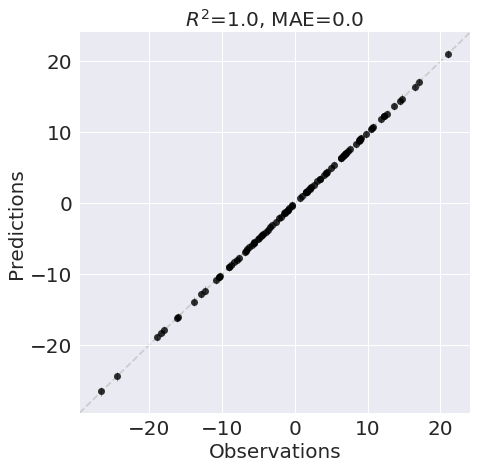

Finished 2.00 percent in 4.202321 s Acceptance rate = 0.7865Adding DE jump with weight 20
Finished 99.00 percent in 179.826767 s Acceptance rate = 0.448293
Run Complete


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,5.242814,4.708435,5.419187,4.885291,3.760537,5.123070,4.548707,5.403047,5.743124,4.935651,24.646050
1,4.739868,4.597311,5.825493,4.629076,5.811119,3.822217,4.964807,5.659868,4.600965,5.561504,24.517306
2,5.667973,5.206287,5.247146,4.082644,4.948181,5.148449,5.890127,6.271013,5.554818,5.346214,24.485581
3,5.014436,4.913761,5.487262,6.092514,6.420485,4.712326,4.258820,4.584529,4.311284,5.143213,24.476371
4,4.303273,4.476750,5.061011,4.534674,5.751372,5.106332,4.902643,4.732441,5.628924,6.572946,24.471578
5,5.981369,5.146391,3.979415,4.053532,4.542317,4.156665,5.119402,4.132194,4.183406,5.363055,24.431280
6,4.923553,5.365302,6.399724,5.883000,5.304723,5.282157,5.837361,4.092775,5.087804,5.774294,24.409138
7,4.997508,3.686236,5.803596,4.813877,4.277179,4.483708,5.926332,5.955806,4.785289,4.436606,24.402015
8,4.722174,4.245861,4.286643,4.345317,6.244807,4.983840,5.010931,3.979099,4.502042,6.138471,24.388871
9,4.752739,4.310847,5.054370,4.049122,3.710961,6.261578,4.496185,5.409283,5.617785,4.532793,24.366217


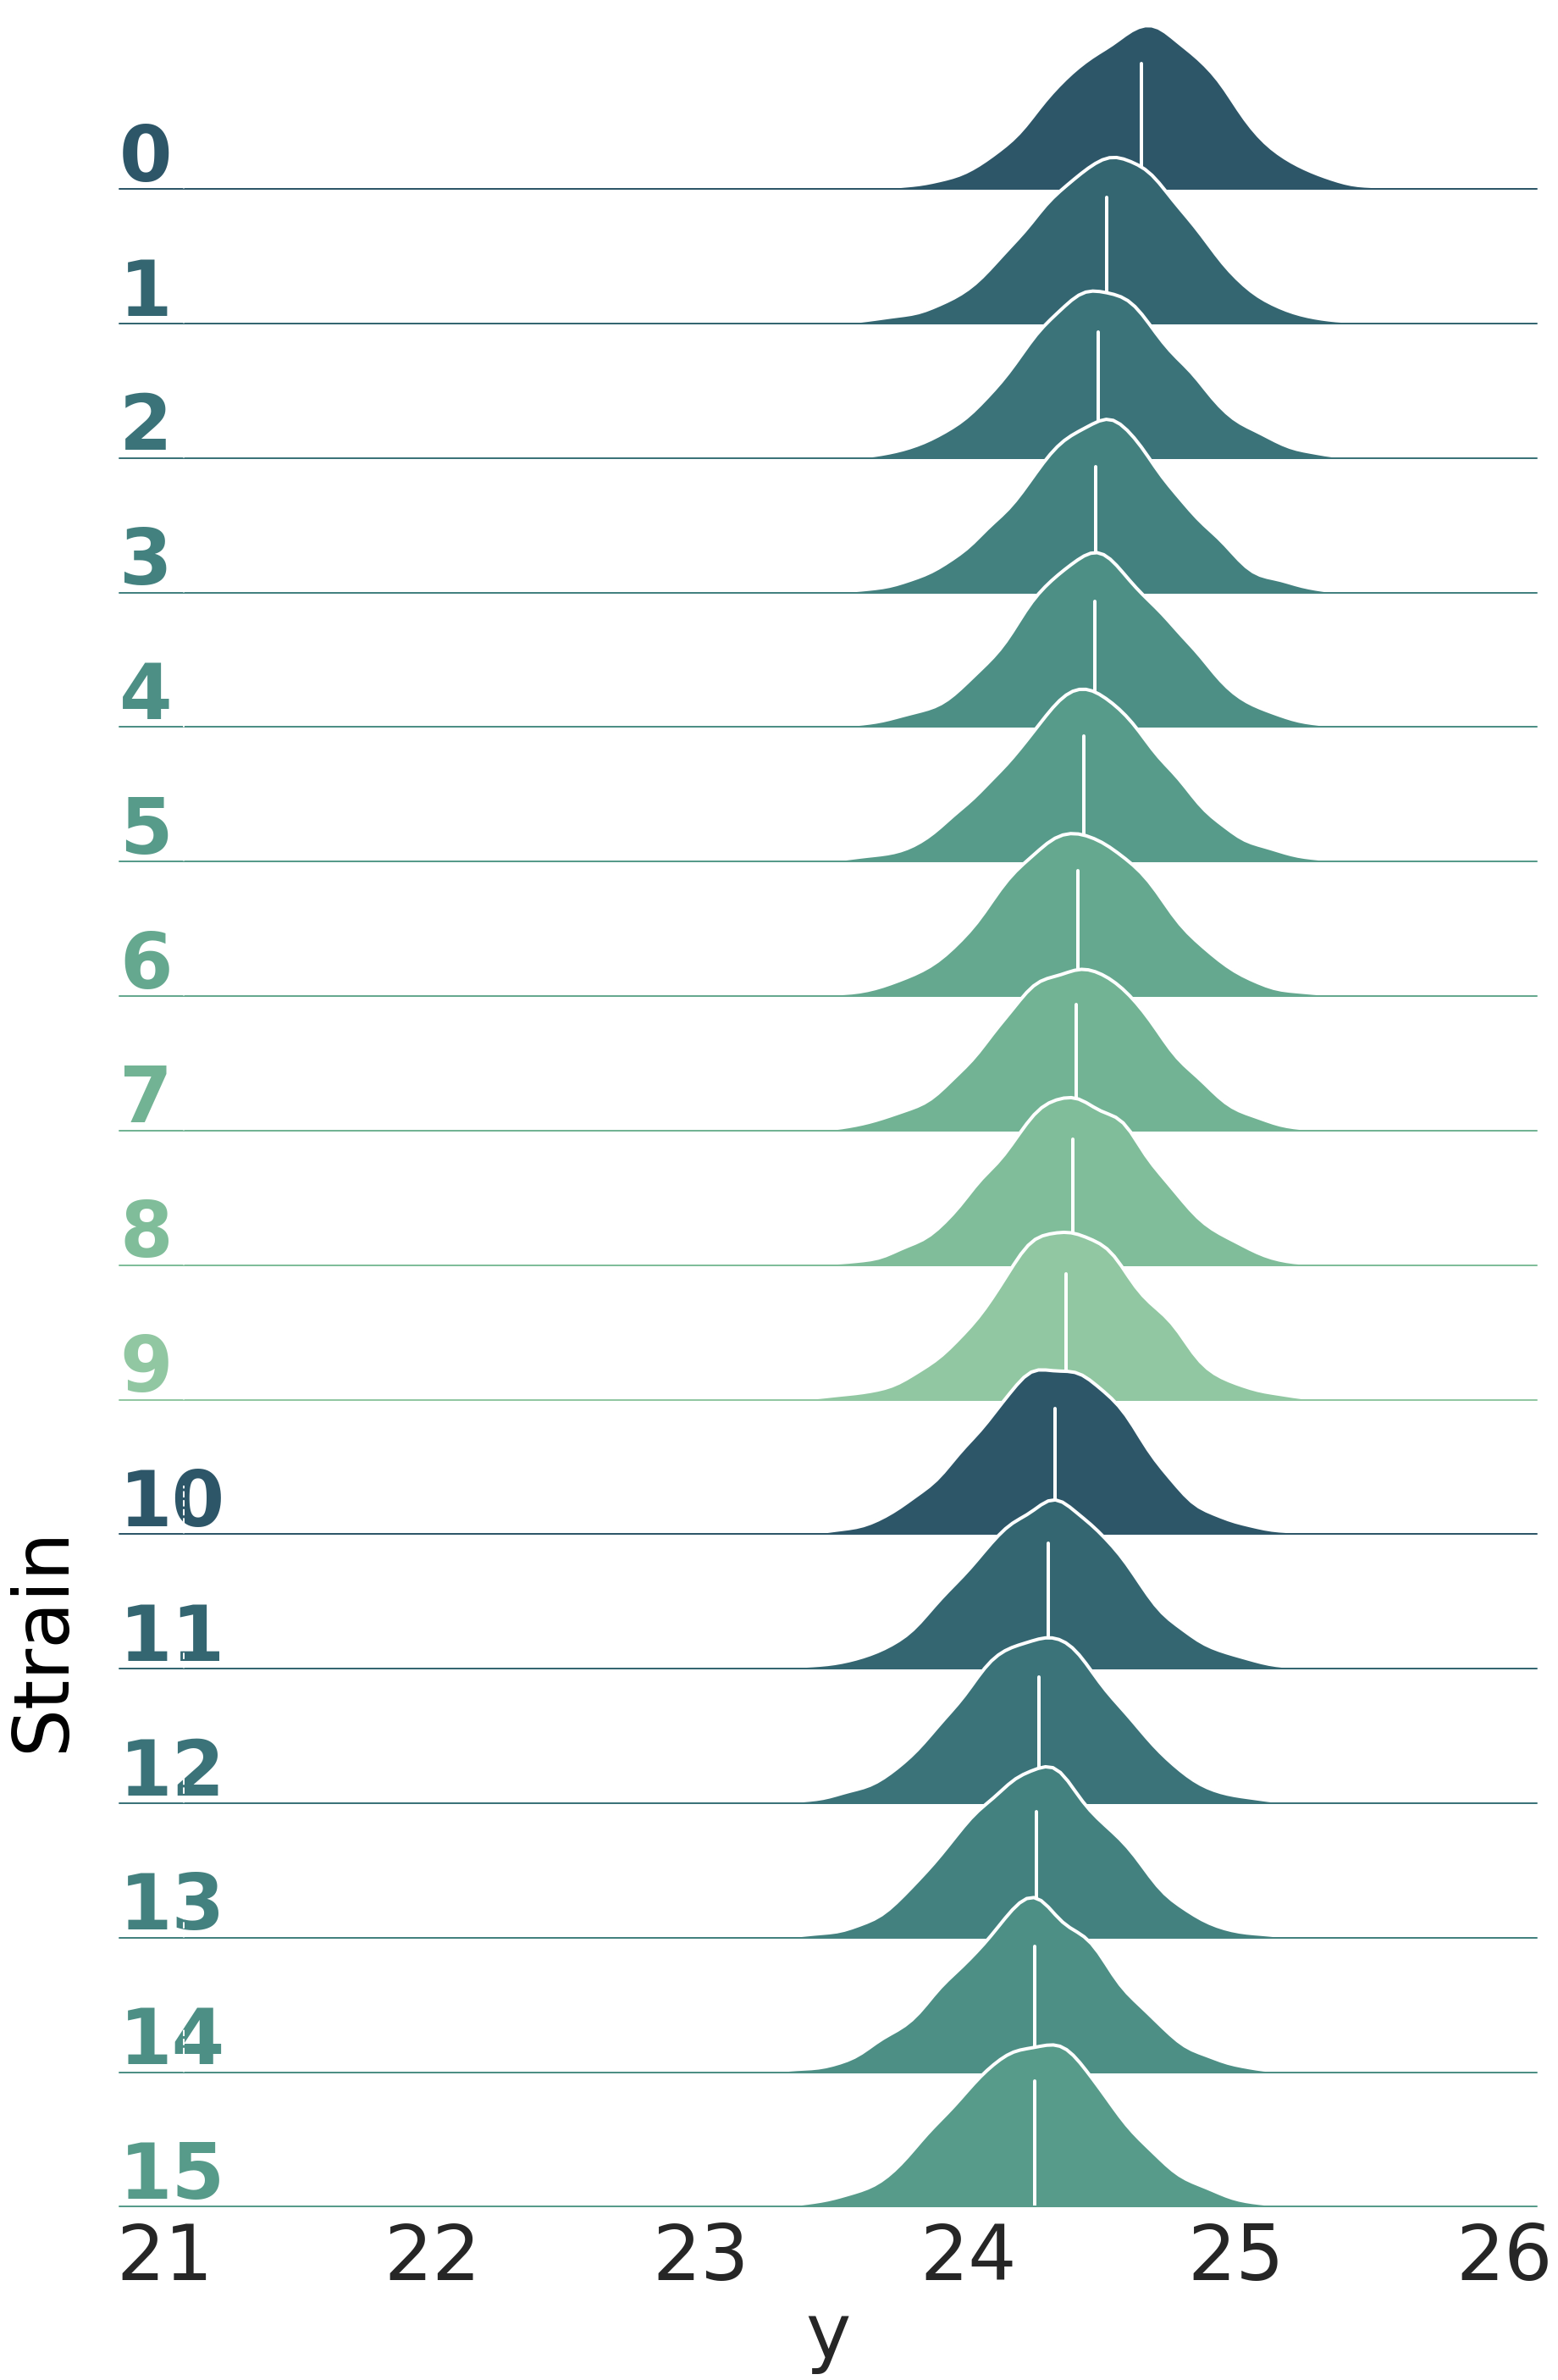

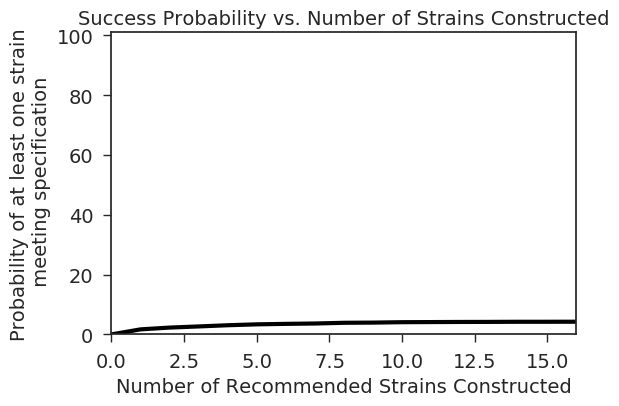

CPU times: user 6min 21s, sys: 1min 4s, total: 7min 25s
Wall time: 6min 13s


In [14]:
%%time
data_file = f'../data/sim_data_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)
art = RecommendationEngine(df, **art_params)

In [16]:
# Save recommendations for the next cycle
file_path = f'{art.outDir}/recommendations_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

In [17]:
# Save data for the next cycle
X_new = art.recommendations.values[:, :-1]
y_new = f1(X_new.T, dim).reshape(-1, 1)
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, file_name)
